# COMPARING K-MEANS CLUSTERS WITH OTHER CLUSTERING ALGORITHMS

In this notebook, we compare the clustering obtained with the K-means method with some hierarchical clustering algorithms.

## IMPORTING NECESSARY PACKAGES

In [1]:
from fragsys_analysis import *

## READING INPUT DATA

In [2]:
main_dir = "./../"
figs_dir = os.path.join(main_dir, "figs")
results_dir = os.path.join(main_dir, "results")

In [3]:
rsa_cluster_dict = load_pickle(os.path.join(results_dir, "rsa_cluster_dict.pkl"))
cluster_membership = load_pickle(os.path.join(results_dir, "rsa_cluster_membership.pkl"))
rsa_profs = load_pickle(os.path.join(results_dir, "rsa_profs.pkl"))
ud_mat = pd.read_pickle(os.path.join(results_dir, "UD_df.pkl"))

## PROCESSING PROFILES

In [4]:
rsa_profs_filt = {k: v for k, v in rsa_profs.items() if len(v) > 1} # filtering out binding sites with a profile shorter than 0 (NONE)
rsa_profs_filt_lens = {k: len(v) for k, v in rsa_profs_filt.items()}
max_len = max(rsa_profs_filt_lens.values())
print(max_len) # maximum RSA profile length, i.e., maximum binding site size

rsa_profs_filt_hmap = {k: sorted(v) for k, v in rsa_profs_filt.items()} # this is needed later for the representation of the LBS RSA-based clusters
for k, v in rsa_profs_filt_hmap.items():
    len_v = len(v)
    none_list = [None] * (max_len - len(v))
    v.extend(none_list)
print(len(rsa_profs_filt))

labs = ud_mat.index.tolist()
idx = [i for i in range(len(ud_mat)) if rsa_profs_filt_lens[labs[i]] > 1]
idx_labs = [labs[i] for i in idx]
ud_mat_subset = ud_mat.loc[idx_labs, idx_labs]

ud_array = np.array(ud_mat_subset)
rsa_profs_filt_hmap_subset = {k: rsa_profs_filt_hmap[k] for k in idx_labs}
rsa_profs_filt_lens_subset = {k: rsa_profs_filt_lens[k] for k in idx_labs}
max_len = max(list(rsa_profs_filt_lens.values()))

rsa_profs_filt_lens_prop = {k:v/max_len for k,v in rsa_profs_filt_lens.items()}
rsa_profs_filt_lens_prop_subset = {k: rsa_profs_filt_lens_prop[k] for k in idx_labs}

40
293


## CLUSTERING WITH K-MEANS

#### K-MEANS CLUSTERING

In [5]:
K = 4

kmeans = KMeans(n_clusters = K, random_state = 0, n_init = 10).fit(ud_array)
kmeans_c_labs = list(kmeans.labels_)
kmeans_cluster_dict = {ud_mat.index.tolist()[i]: kmeans_c_labs[i] for i in range(len(kmeans_c_labs))}

In [6]:
renaming_clusters_dict = {0:3, 1:1, 2:4, 3:2}
kmeans_cluster_dict_new = {k:renaming_clusters_dict[v] for k,v in kmeans_cluster_dict.items()}
kmeans_c_labs_new = [renaming_clusters_dict[lab] for lab in kmeans_c_labs]

### VISUALISATION OF THE K-MEANS CLUSTERS - I: BINDING SITES VECTOR REPRESENTATION

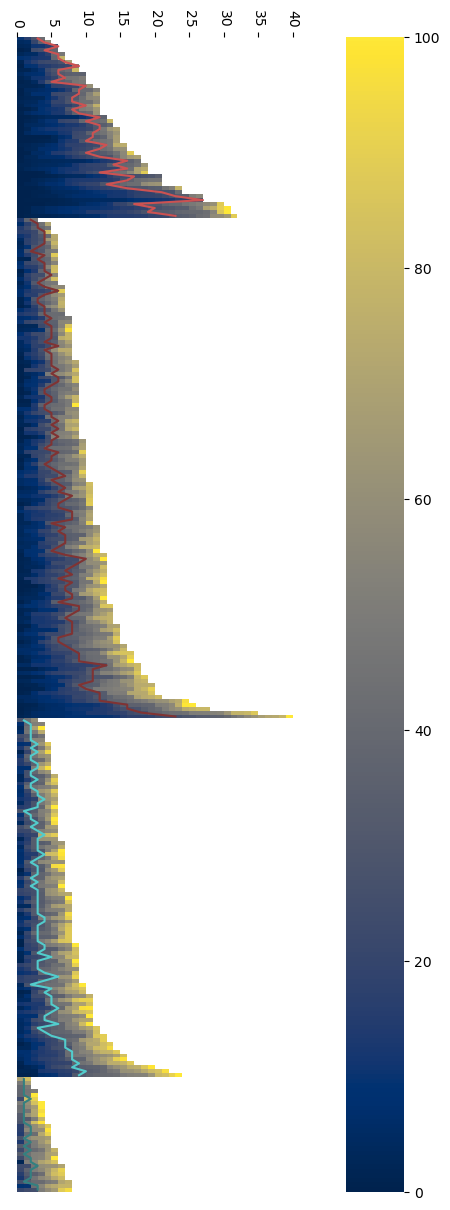

In [7]:
c_labs = [1, 2, 3, 4]

nks = [kmeans_c_labs_new.count(i) for i in c_labs]

plot_clusters(
    rsa_profs_filt_hmap_subset, rsa_profs_filt_lens_subset, kmeans_cluster_dict_new, nks, c_labs, rsa_t = 25,
    fsize = (5, 15), dpi = 100, cmap = "cividis", out = None, show = True, rsa_t_lw = 1.5
)


In [8]:
kmeans_site_color_dict = {k:matplotlib.colors.to_hex(sample_colors[v-1]) for k, v in kmeans_cluster_dict_new.items()}
un_labs = list(set(kmeans_c_labs_new))
kmeans_membership = {un_lab:[k for k, v in kmeans_cluster_dict_new.items() if v == un_lab] for un_lab in un_labs}

### VISUALISATION OF THE K-MEANS CLUSTERS - II: MULTI DIMENSIONAL SCALING (MDS)

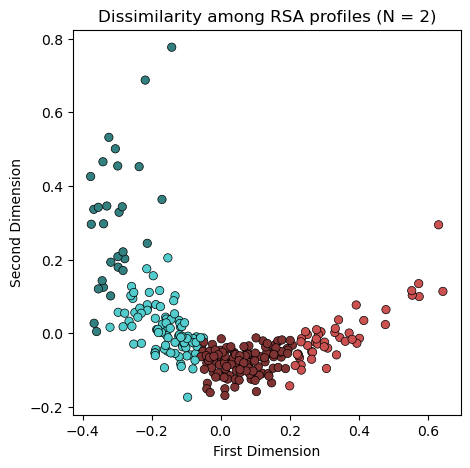

In [9]:
n = 2
cols = list(kmeans_site_color_dict.values())
mds_model = sklearn.manifold.MDS(n_components = n, random_state = 123,
    dissimilarity = 'precomputed', normalized_stress = False)
mds_fit = mds_model.fit(ud_mat_subset)  
mds_coords = mds_model.fit_transform(ud_mat_subset)

plt.figure(figsize=(5, 5), dpi= 100)
plt.scatter(
        mds_coords[:,0],mds_coords[:,1],
        color = cols, edgecolors = "k", 
        linewidth = 0.5, marker = "o"
        )
plt.xlabel('First Dimension')
plt.ylabel('Second Dimension')
plt.title('Dissimilarity among RSA profiles (N = {})'.format(n))

#plt.savefig(os.path.join(main_dir, "figs", "rsa_distrs_kmeans_reordered_n.png".format(n)))

plt.show()

### EXPLORING LIGAND BINDING SITE HIERARCHICAL CLUSTERING

In [10]:
rsa_t = 25

#### SINGLE LINKAGE CLUSTERING

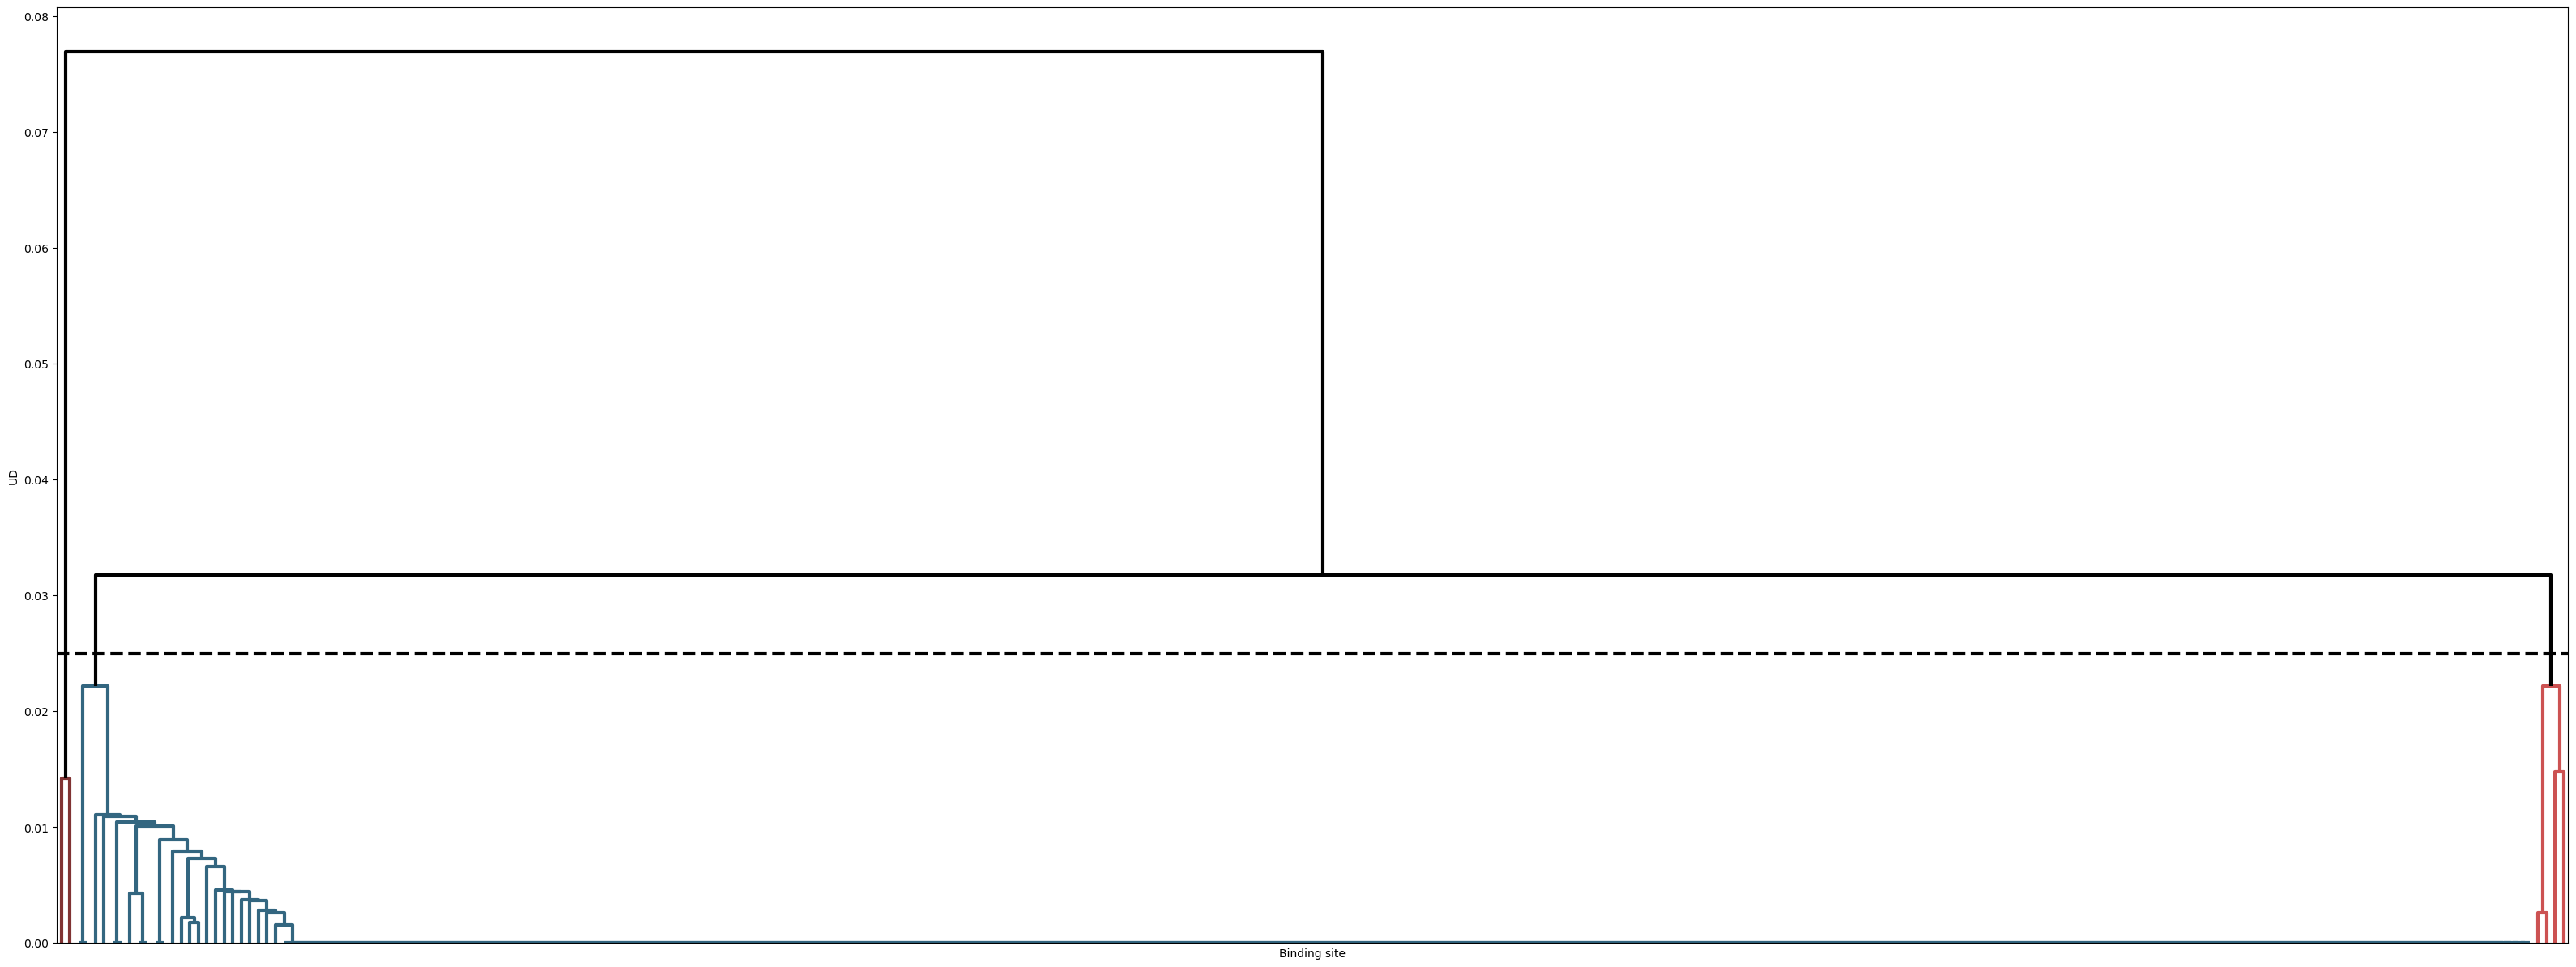

In [13]:
met = "single"
t = 0.025

site_cluster_dict, cluster_ids, n_clusters = plot_color_dd(ud_mat_subset, met, t, sample_colors) #os.path.join(main_dir, "figs", "rsa_distrs_tree_{}_{}.png".format(met, t))

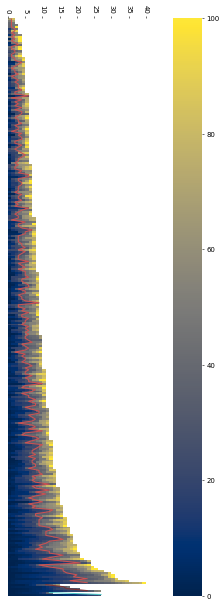

In [15]:
c_labs = list(range(n_clusters))

nks = [cluster_ids.count(i) for i in c_labs]

plot_clusters(
    rsa_profs_filt_hmap_subset, rsa_profs_filt_lens_subset, site_cluster_dict, nks, c_labs, rsa_t = rsa_t,
    fsize = (5, 15), dpi = 50, cmap = "cividis", out = None, show = True, rsa_t_lw = 1.5
)

#### COMPLETE LINKAGE CLUSTERING

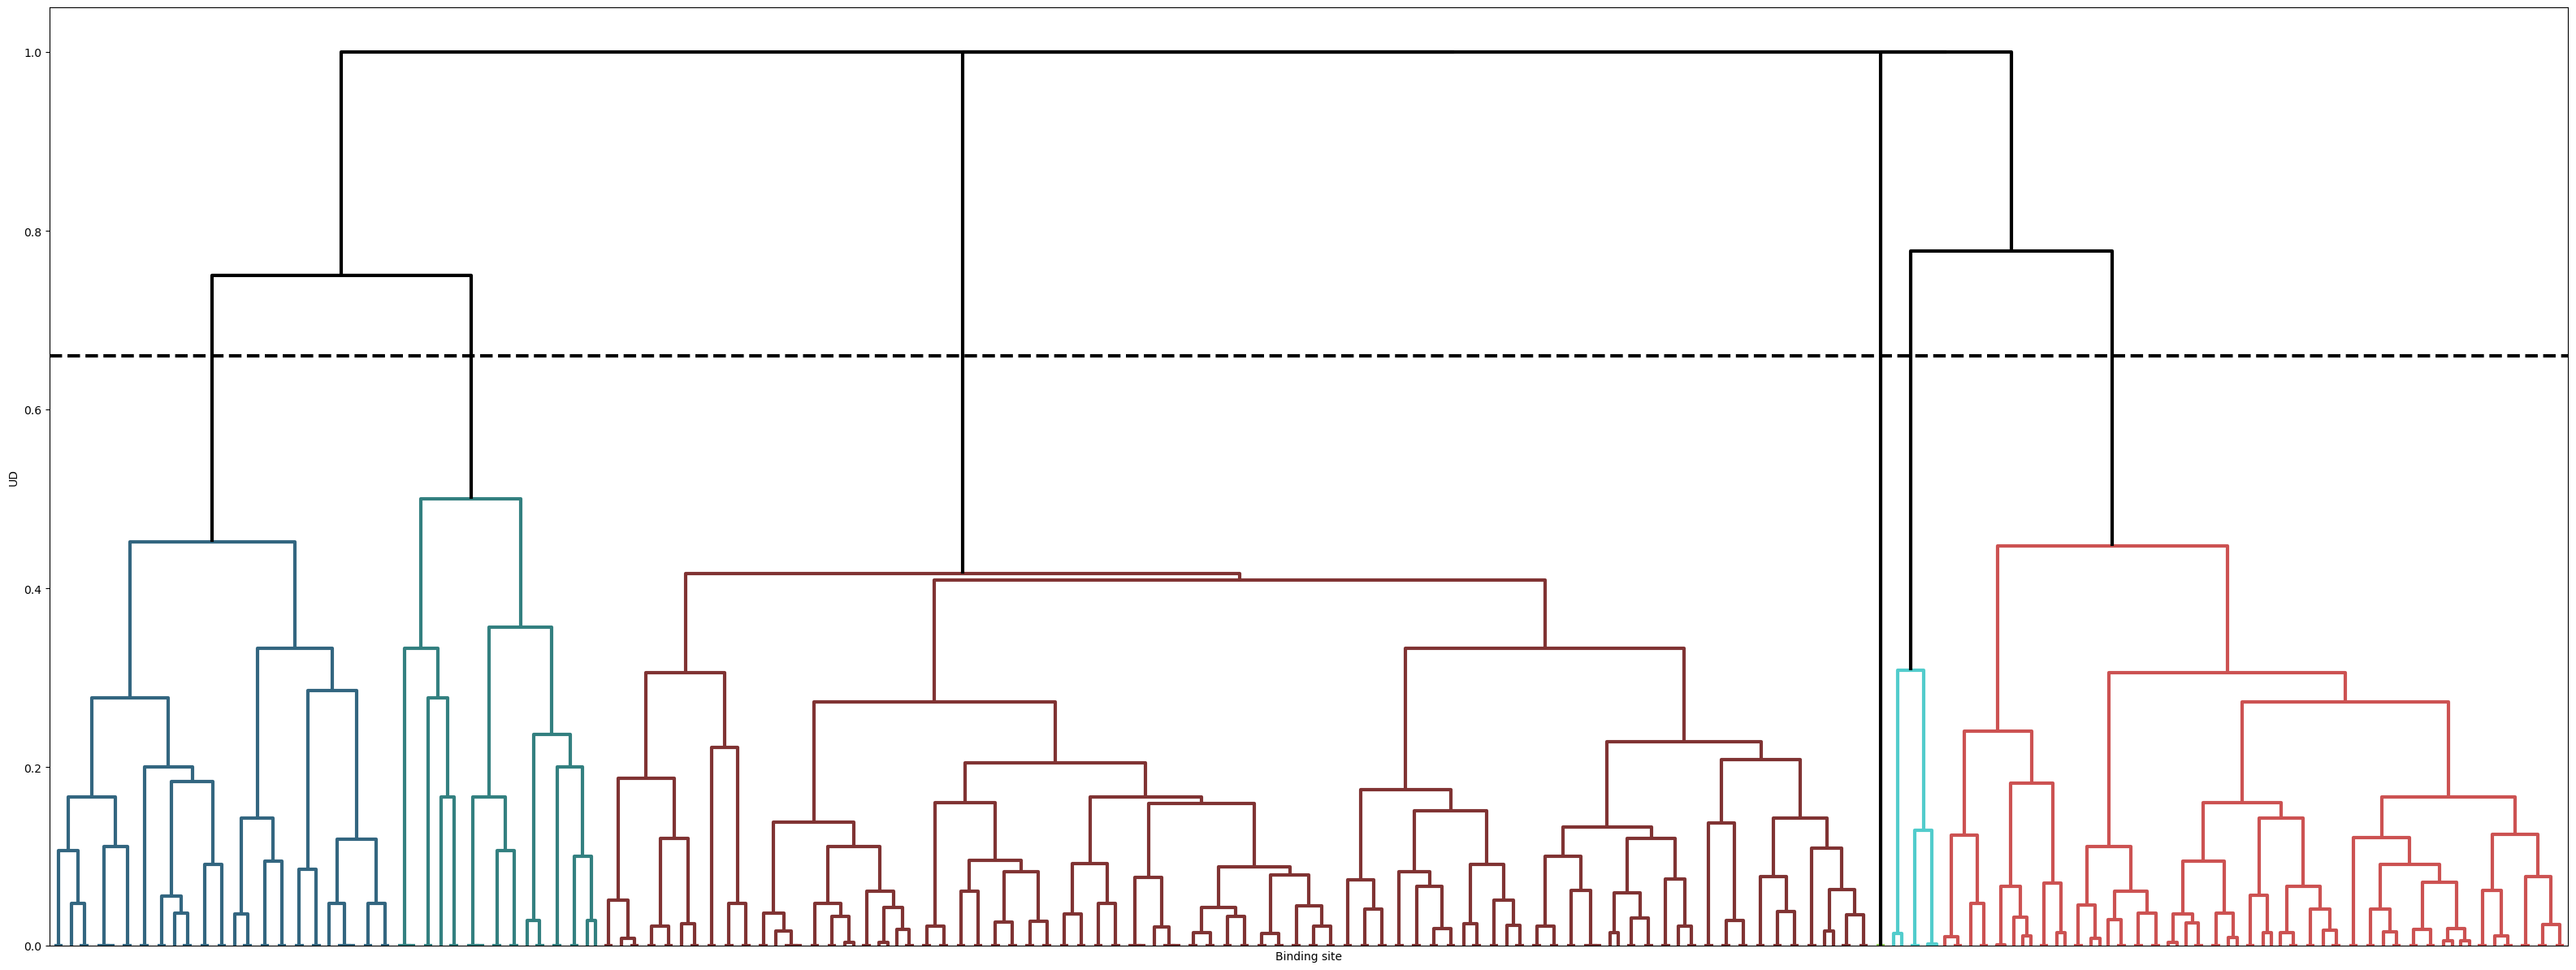

In [17]:
met = "complete"
t = 0.66

site_cluster_dict, cluster_ids, n_clusters = plot_color_dd(ud_mat_subset, met, t, sample_colors) #os.path.join(main_dir, "figs", "rsa_distrs_tree_{}_{}.png".format(met, t))

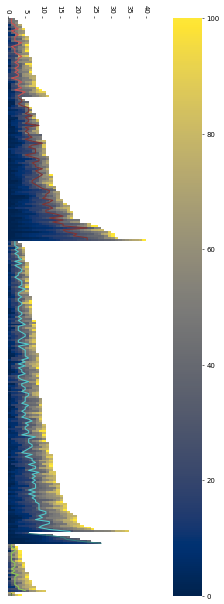

In [19]:
c_labs = list(range(n_clusters))

nks = [cluster_ids.count(i) for i in c_labs]

plot_clusters(
    rsa_profs_filt_hmap_subset, rsa_profs_filt_lens_subset, site_cluster_dict, nks, c_labs, rsa_t = rsa_t,
    fsize = (5, 15), dpi = 50, cmap = "cividis", out = None, show = True, rsa_t_lw = 1.5
)

#### UPGMA (AVERAGE)  CLUSTERING

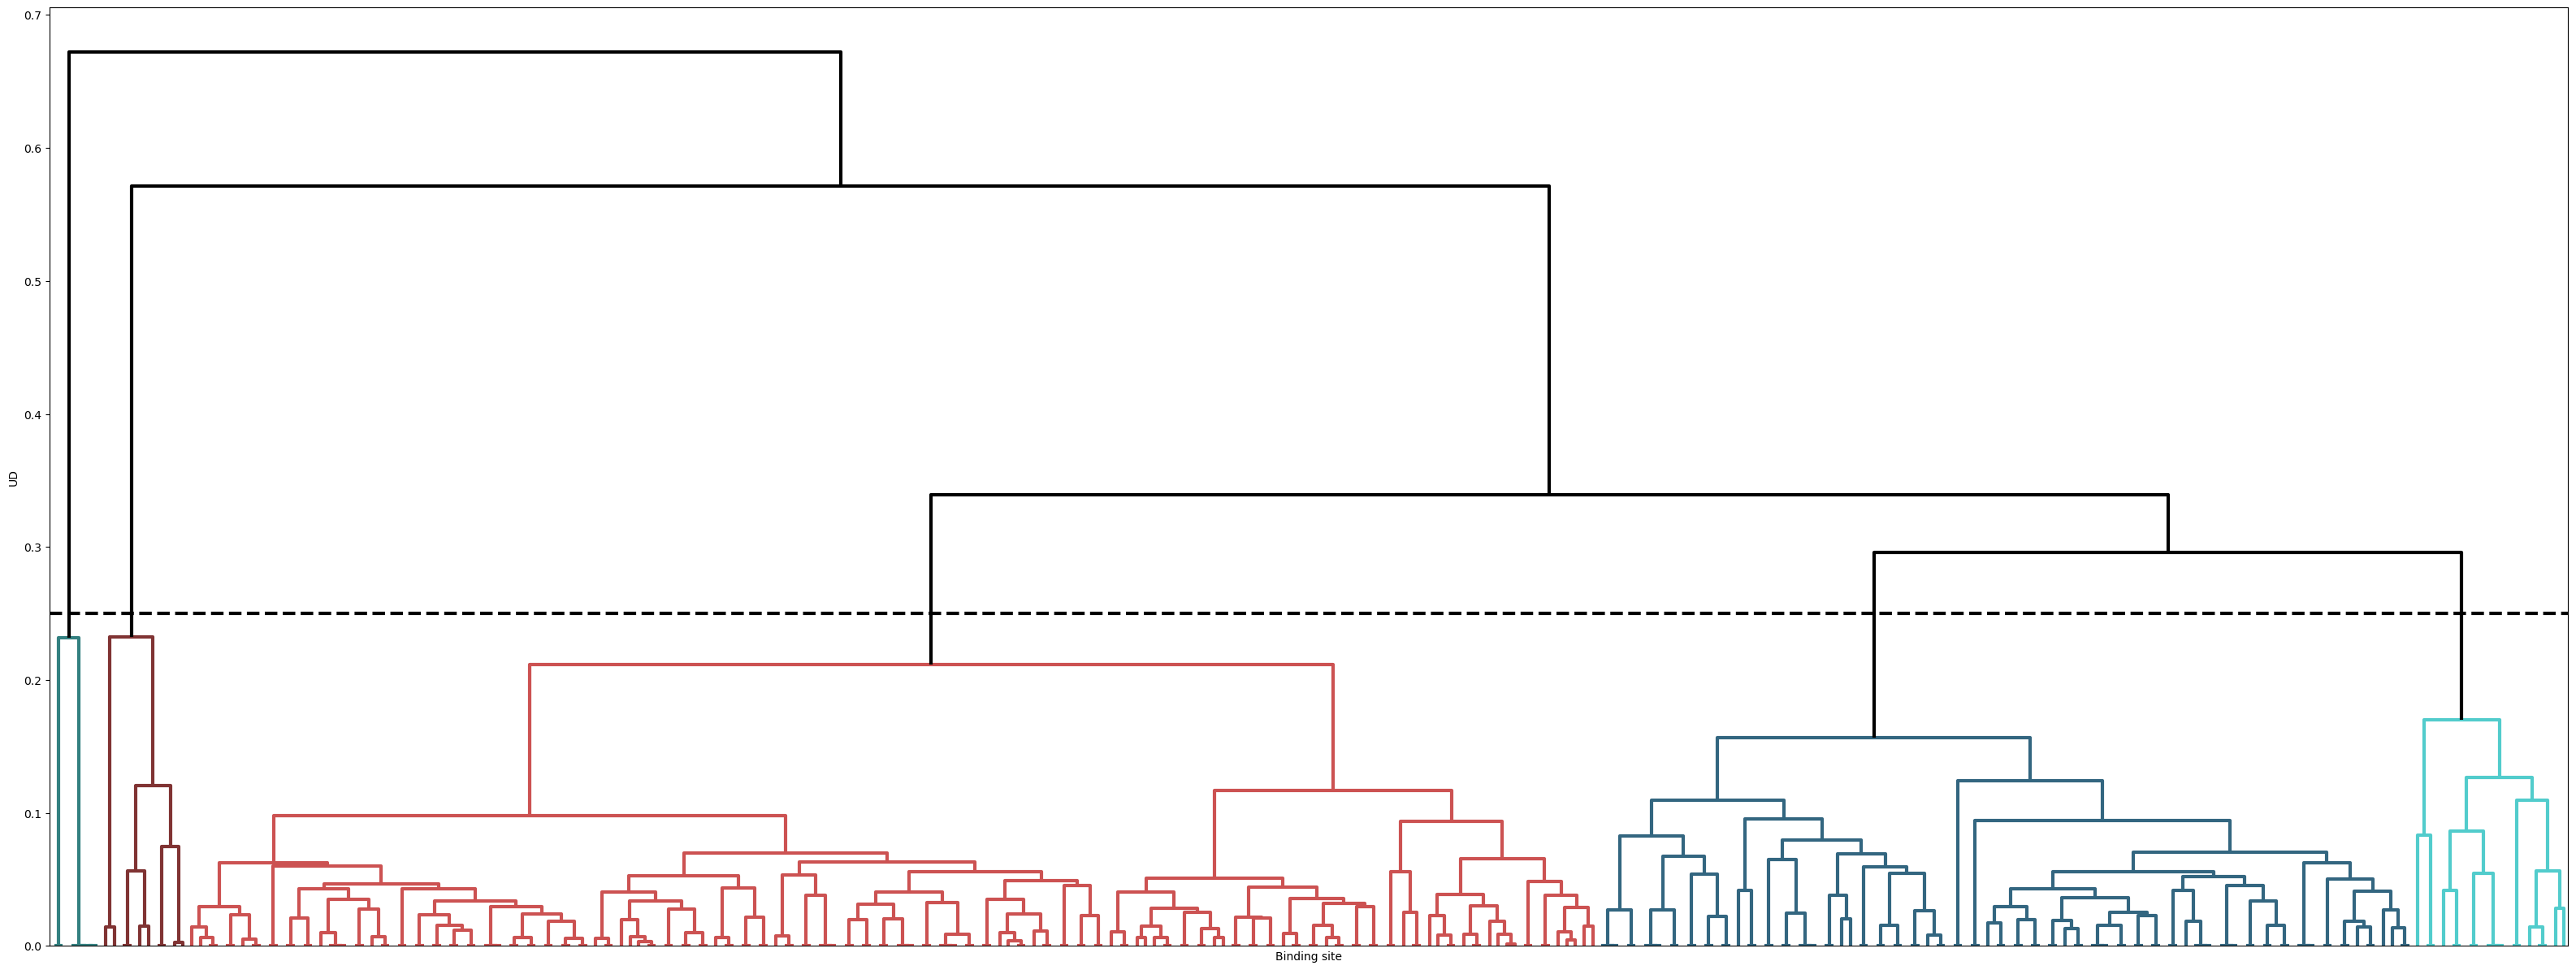

In [49]:
met = "average"
t = 0.25
site_cluster_dict, cluster_ids, n_clusters = plot_color_dd(ud_mat_subset, met, t, sample_colors) #os.path.join(main_dir, "figs", "rsa_distrs_tree_{}_{}.png".format(met, t))

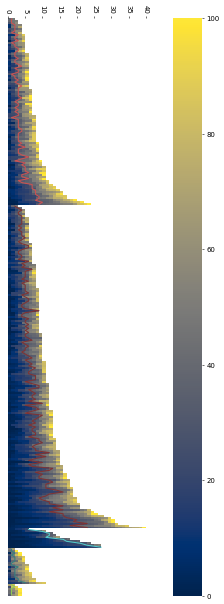

In [48]:
site_cluster_dict = {k: v+1 for k, v in site_cluster_dict.items()}
c_labs = sorted(list(set(site_cluster_dict.values())))
cluster_ids = [i+1 for i in cluster_ids]
nks = [cluster_ids.count(i) for i in c_labs]

plot_clusters(
    rsa_profs_filt_hmap_subset, rsa_profs_filt_lens_subset, site_cluster_dict, nks, c_labs, rsa_t = rsa_t,
    fsize = (5, 15), dpi = 50, cmap = "cividis", out = None, show = True, rsa_t_lw = 1.5
)

#### WPGMA (WEIGHTED) LINKAGE CLUSTERING

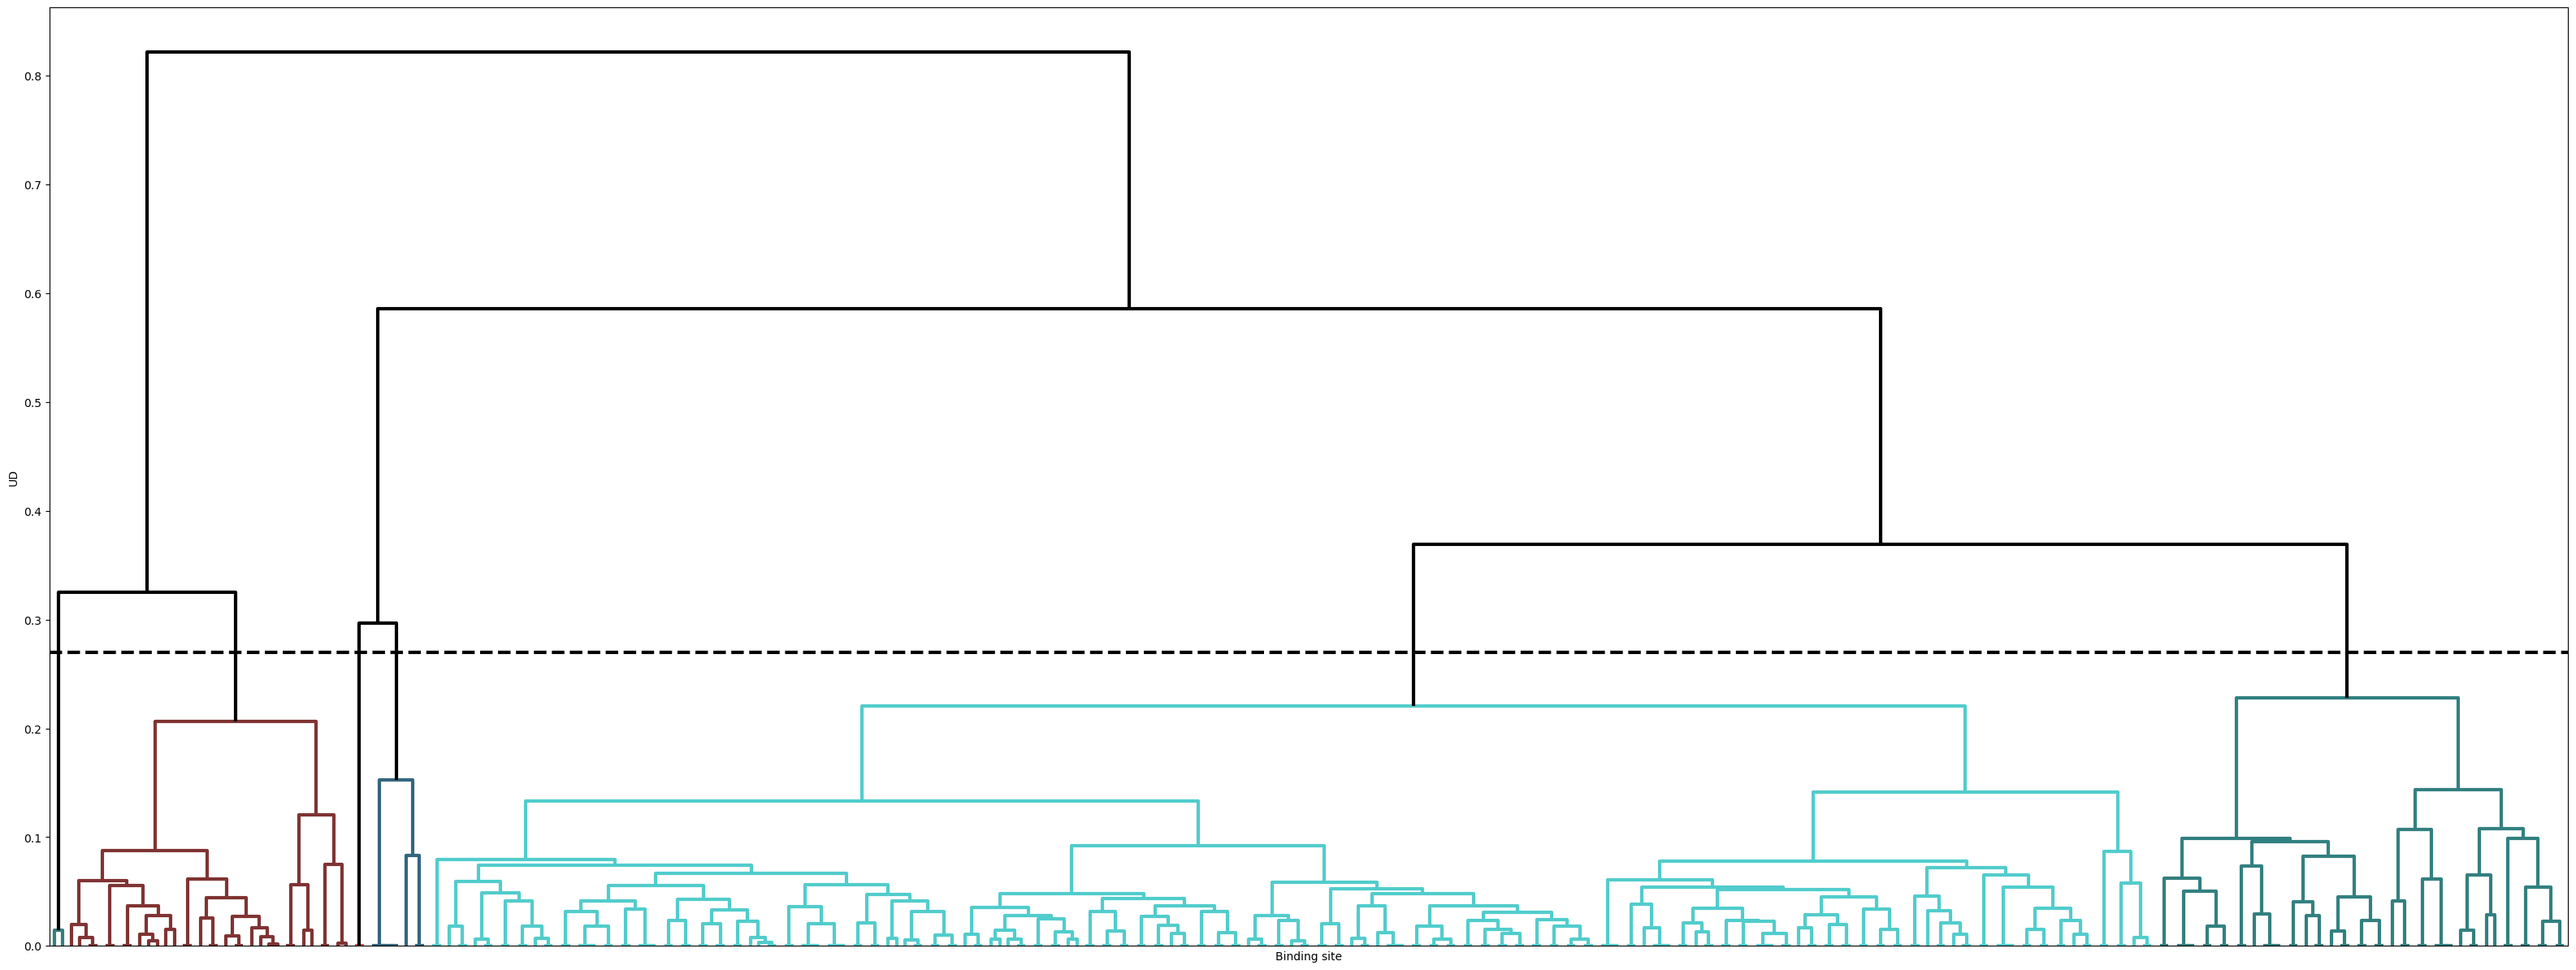

In [50]:
met = "weighted"
t = 0.27

site_cluster_dict, cluster_ids, n_clusters = plot_color_dd(ud_mat_subset, met, t, sample_colors) #os.path.join(main_dir, "figs", "rsa_distrs_tree_{}_{}.png".format(met, t))

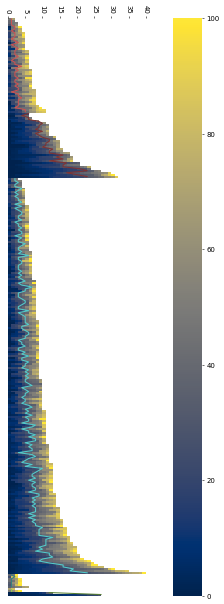

In [53]:
c_labs = list(range(n_clusters))

nks = [cluster_ids.count(i) for i in c_labs]

plot_clusters(
    rsa_profs_filt_hmap_subset, rsa_profs_filt_lens_subset, site_cluster_dict, nks, c_labs, rsa_t = rsa_t,
    fsize = (5, 15), dpi = 50, cmap = "cividis", out = None, show = True, rsa_t_lw = 1.5
)

#### UPGMC (CENTROID) LINKAGE CLUSTERING

##### WEIRD TREE REVERSALS WITH UPGMC MEANS THE TREE IS NOT PROPERLY CUT

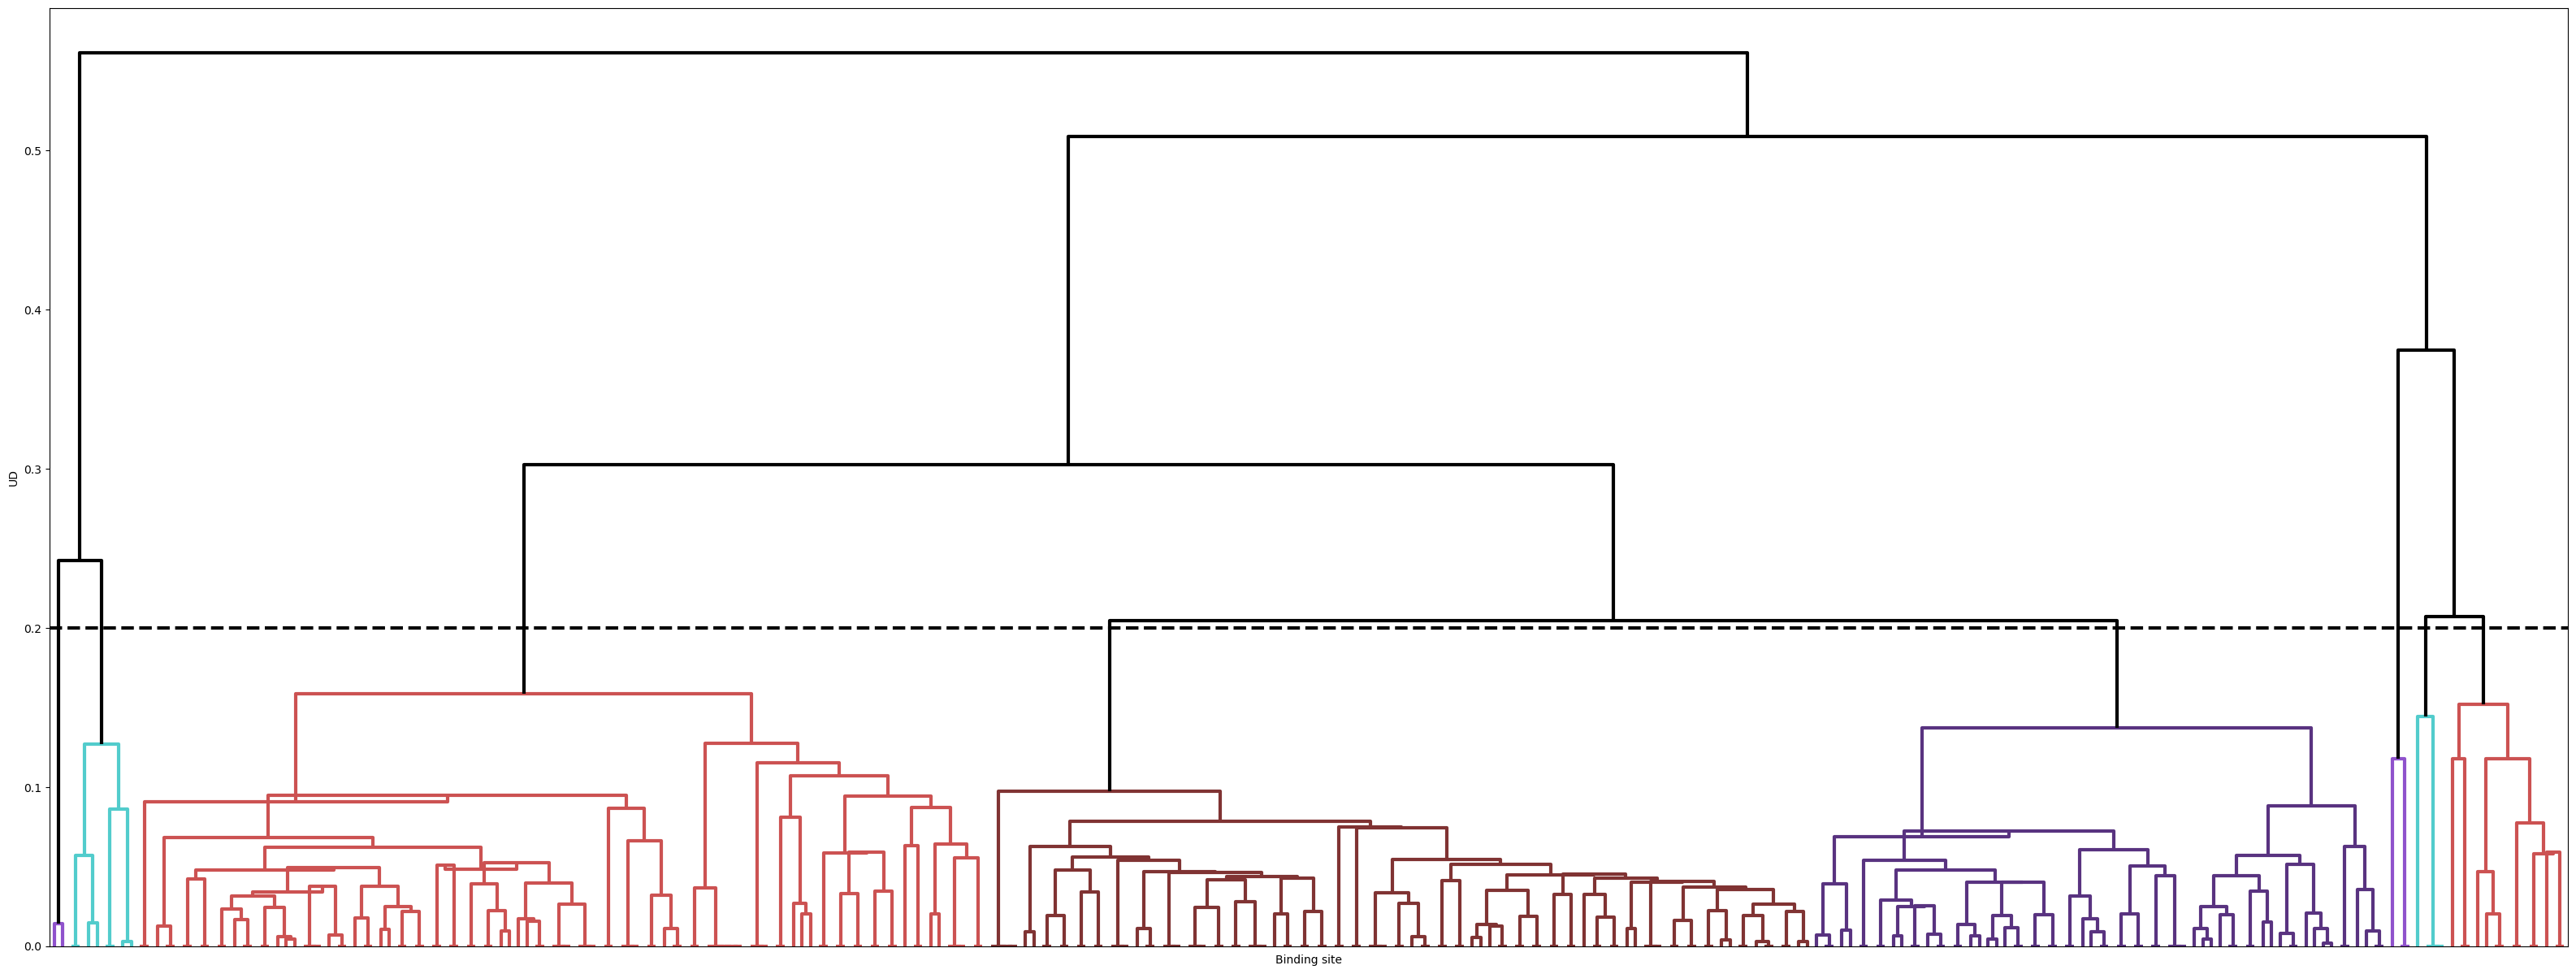

In [69]:
met = "centroid"
t = 0.2

site_cluster_dict, cluster_ids, n_clusters = plot_color_dd(ud_mat_subset, met, t, sample_colors) #os.path.join(main_dir, "figs", "rsa_distrs_tree_{}_{}.png".format(met, t))

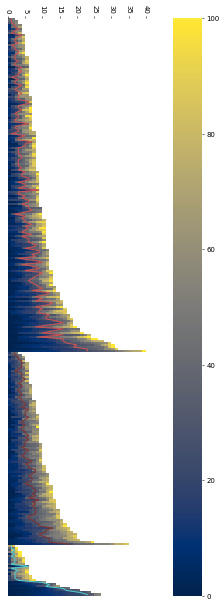

In [75]:
nks = [cluster_ids.count(i) for i in range(n_clusters)]

plot_clusters(
    rsa_profs_filt_hmap_subset, rsa_profs_filt_lens_subset, site_cluster_dict, nks, n_clusters, rsa_t = rsa_t,
    fsize = (5, 15), dpi = 50, cmap = "cividis", out = None, show = True, rsa_t_lw = 1.5
)

#### WPGMC (MEDIAN) LINKAGE CLUSTERING

##### WEIRD TREE REVERSALS WITH UPGMC MEANS THE TREE IS NOT PROPERLY CUT

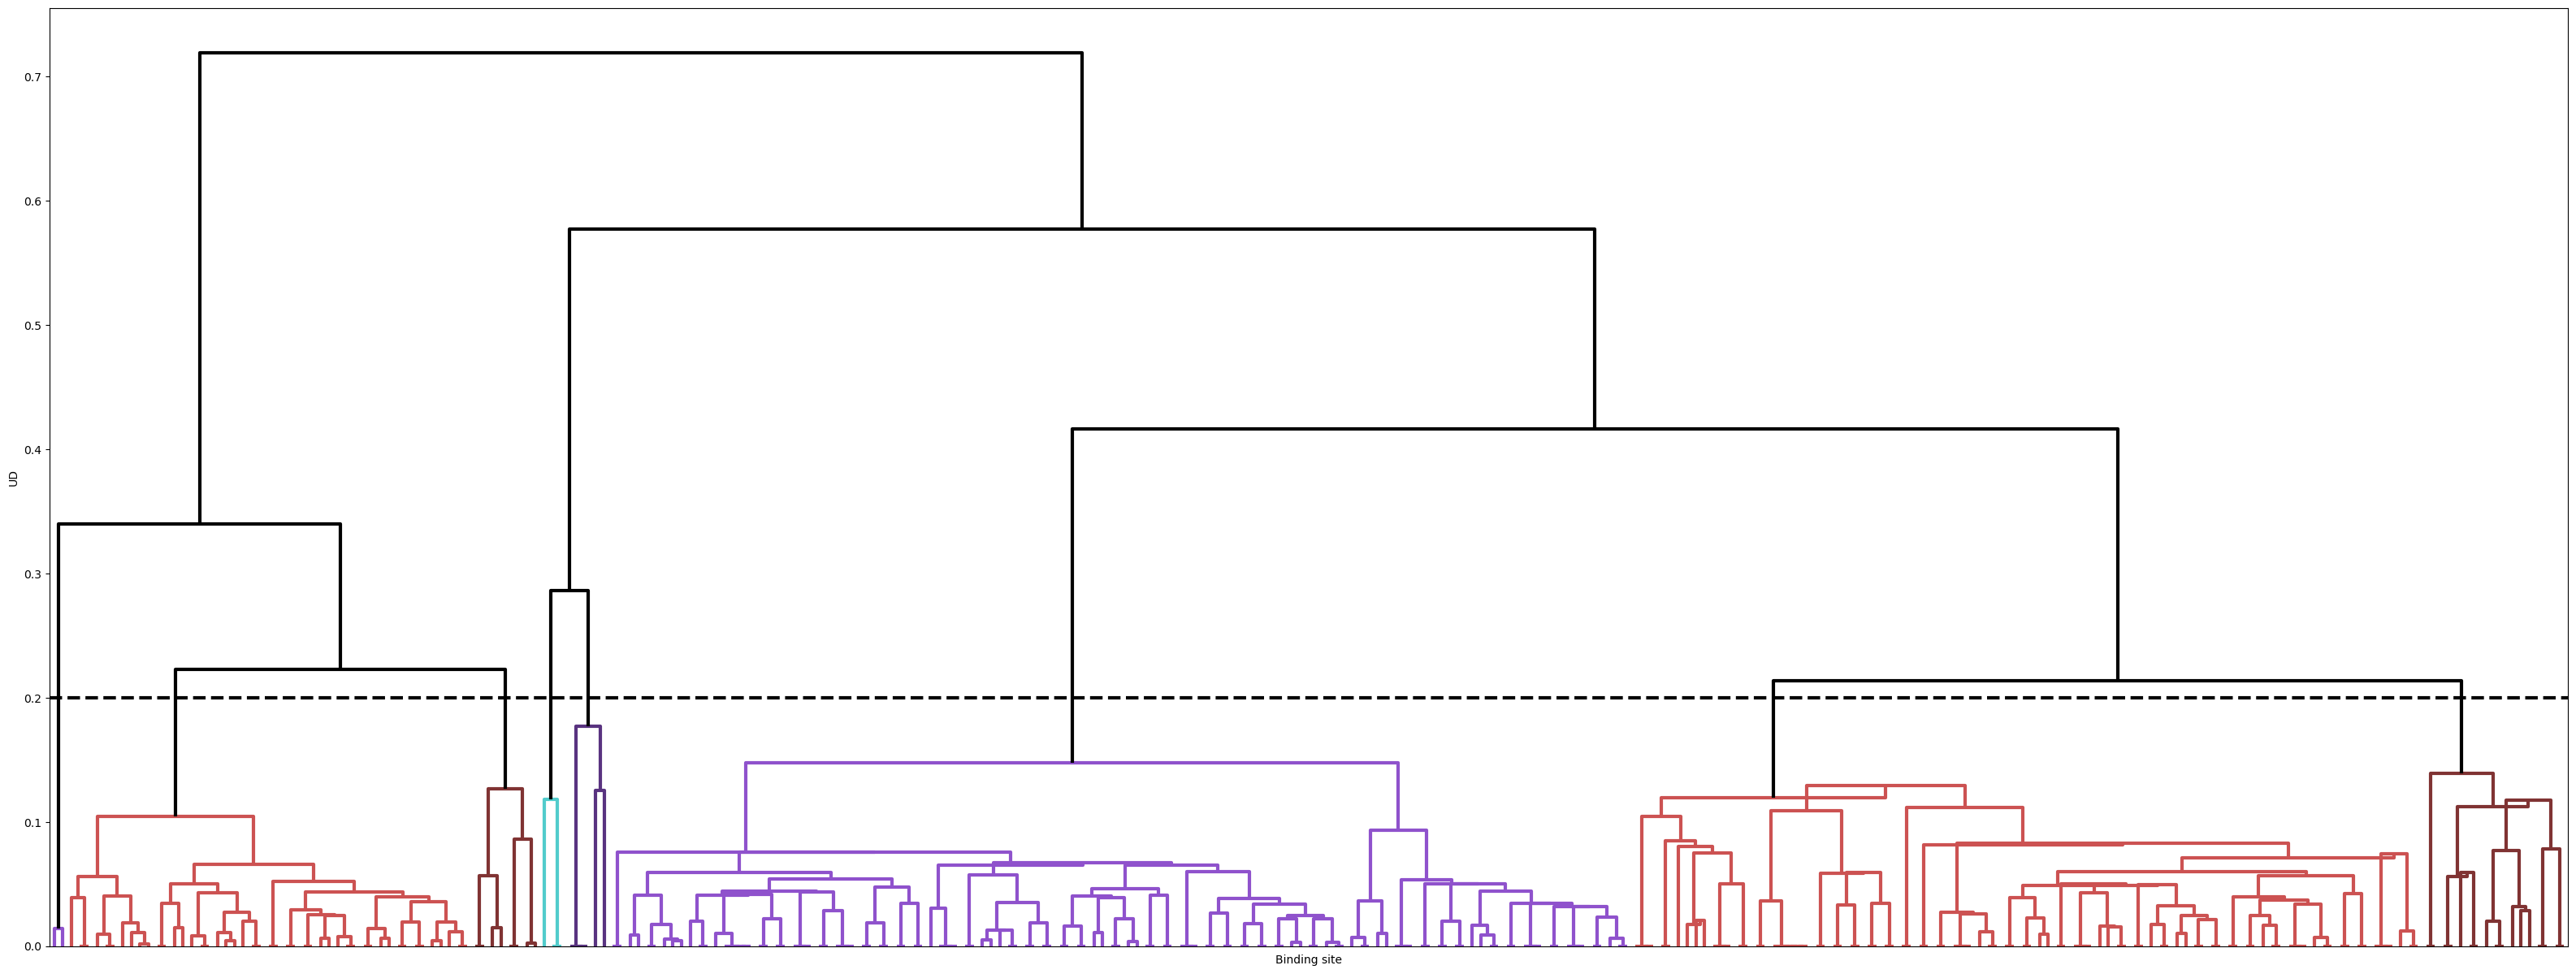

In [77]:
met = "median"
t = 0.2

site_cluster_dict, cluster_ids, n_clusters = plot_color_dd(ud_mat_subset, met, t, sample_colors) #os.path.join(main_dir, "figs", "rsa_distrs_tree_{}_{}.png".format(met, t))

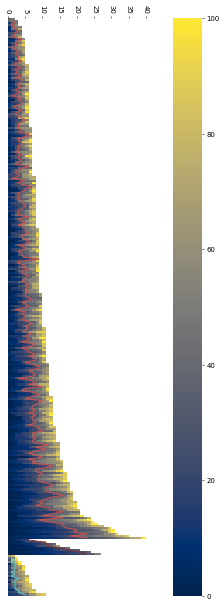

In [79]:
nks = [cluster_ids.count(i) for i in range(n_clusters)]

plot_clusters(
    rsa_profs_filt_hmap_subset, rsa_profs_filt_lens_subset, site_cluster_dict, nks, n_clusters, rsa_t = rsa_t,
    fsize = (5, 15), dpi = 50, cmap = "cividis", out = None, show = True, rsa_t_lw = 1.5
)

#### WARD LINKAGE CLUSTEIRNG

In [50]:
def plot_color_dd_LOC1(dist_mat, clust_method, dist_t):
    """
    plots a dendrogram coloured according to the cluster labels
    generated by the linkage
    """
    z_c = scipy.cluster.hierarchy.linkage(
        scipy.spatial.distance.squareform(dist_mat),
        method = clust_method, optimal_ordering = True
    )

    ks = dist_mat.index.tolist()
    
    cutree = scipy.cluster.hierarchy.cut_tree(z_c, height = dist_t) # clusters coordinates
    cluster_ids = [int(cut) for cut in cutree]
    site_cluster_dict = {ks[i]: cluster_ids[i] for i in range(len(ks))}
    n_clusters = len(set(cluster_ids))
    return site_cluster_dict, cluster_ids, n_clusters, z_c, ks
    

In [51]:
def plot_color_dd_LOC2(linkage_mat, site_cluster_dict, ks, dist_t, n_clusters, sample_colors, out = None, show = True):
    
    plt.rcParams['lines.linewidth'] = 3

    fig = plt.figure(figsize=(80, 30), dpi = 300)
    plt.axhline(dist_t, linestyle = "--", linewidth = 3, color = "black")   
    dd = scipy.cluster.hierarchy.dendrogram(linkage_mat, no_labels = False, labels = ks, leaf_font_size = 10, color_threshold = dist_t, above_threshold_color = "black")
    plt.xlabel("Binding site")
    plt.ylabel("UD")

    dd_labs = dd["ivl"]
    dd_c_labs = [site_cluster_dict[i] for i in dd_labs]
    ordered_labs = list(dict(zip(dd_c_labs, dd_c_labs)))
    scipy.cluster.hierarchy.set_link_color_palette([matplotlib.colors.to_hex(sample_colors[i]) for i in ordered_labs])
    if out!= None:
        plt.savefig(out)
    if show == True:
        plt.show()

In [57]:
met = "ward"
t = 1.8

site_cluster_dict, cluster_ids, n_clusters, z_c, ks = plot_color_dd_LOC1(ud_mat_subset, met, t) #os.path.join(main_dir, "figs", "rsa_distrs_tree_{}_{}.png".format(met, t))
renaming_clusters_dict_ward = {0:2, 1:0, 2:1, 3:3}
#renaming_clusters_dict_ward = {0:0, 1:1, 2:2, 3:3}

ward_cluster_dict_new = {k:renaming_clusters_dict_ward[v] for k,v in site_cluster_dict.items()}
plot_color_dd_LOC2(z_c, ward_cluster_dict_new, ks, t, n_clusters, sample_colors, out = os.path.join(main_dir, "figs", "rsa_distrs_tree_ward_1.8_wlabels_optimal.png"))

In [ ]:
plot_color_dd_LOC2(z_c, ward_cluster_dict_new, ks, t, n_clusters, sample_colors, out = os.path.join(main_dir, "figs", "rsa_distrs_tree_ward_1.8_wlabels_optimal.png"))

In [ ]:
{'P0C024_0_BS0': 0.689,
 'Q9UGL1_0_BS2': 0.955,
 'Q6B0I6_0_BS8': 0.955,
 'P11838_0_BS8': 0.689}

In [46]:
ward_cluster_dict_new["P0C024_0_BS0"]

1

In [47]:
ward_cluster_dict_new["Q9UGL1_0_BS2"]

0

In [48]:
ward_cluster_dict_new["Q6B0I6_0_BS8"]

0

In [49]:
ward_cluster_dict_new["P11838_0_BS8"]

2

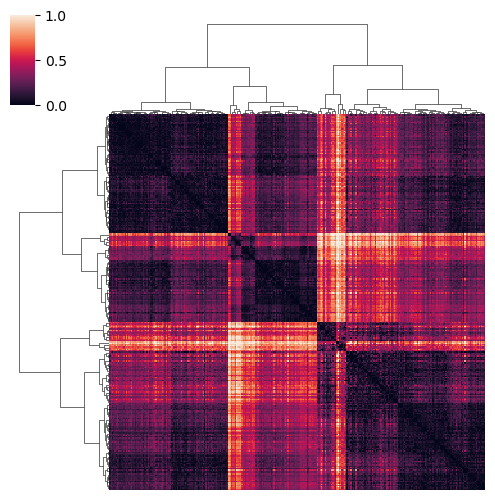

In [43]:
#plt.figure(figsize = (6,6), dpi = 300)
linkage = scipy.cluster.hierarchy.linkage(scipy.spatial.distance.squareform(ud_mat_subset), method = 'ward', optimal_ordering = False)
ax = sns.clustermap(ud_mat_subset, xticklabels = False, yticklabels = False, row_linkage=linkage, col_linkage=linkage, figsize = (5,5))#, cmap = "Reds_r")
#ax.figure.savefig(os.path.join(main_dir, "figs", "rsa_distrs_clustermap_ward.png"),dpi=300)#()
plt.show()

In [65]:
cluster_ids_new = [renaming_clusters_dict_ward[i] for i in cluster_ids]

In [66]:
ward_membership = {un_lab: set([k for k, v in ward_cluster_dict_new.items() if v == un_lab]) for un_lab in un_labs}

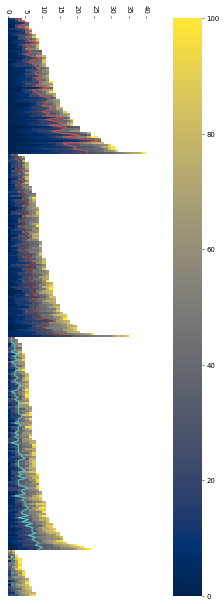

In [73]:
c_labs = [1,2,3,4]

nks = [cluster_ids_new.count(i) for i in c_labs]

plot_clusters(
    rsa_profs_filt_hmap_subset, rsa_profs_filt_lens_subset, ward_cluster_dict_new, nks, c_labs, rsa_t = rsa_t,
    fsize = (5, 15), dpi = 50, cmap = "cividis", out = None, show = True, rsa_t_lw = 1.5
)

In [76]:
ward_site_color_dict = {k:matplotlib.colors.to_hex(sample_colors[v-1]) for k, v in ward_cluster_dict_new.items()}

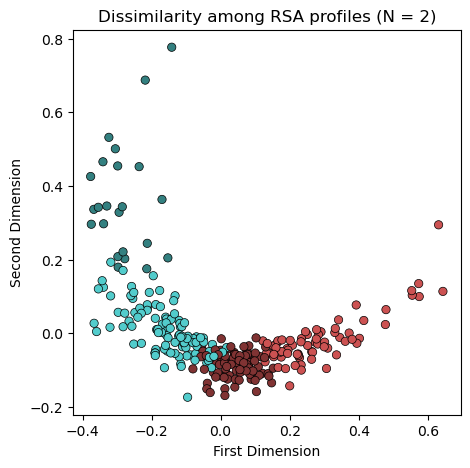

In [77]:
n = 2
cols = list(ward_site_color_dict.values())
mds_model = sklearn.manifold.MDS(n_components = n, random_state = 123,
    dissimilarity = 'precomputed', normalized_stress = False)
mds_fit = mds_model.fit(ud_mat_subset)  
mds_coords = mds_model.fit_transform(ud_mat_subset)

plt.figure(figsize=(5, 5), dpi= 100)
plt.scatter(
        mds_coords[:,0],mds_coords[:,1],
        color = cols, edgecolors = "k", 
        linewidth = 0.5, marker = "o"
        )
plt.xlabel('First Dimension')
plt.ylabel('Second Dimension')
plt.title('Dissimilarity among RSA profiles (N = {})'.format(n))

#plt.savefig(os.path.join(main_dir, "figs", "rsa_distrs_kmeans_reordered_n.png".format(n)))

plt.show()

In [81]:
intersects = []
for un_lab_k in un_labs:
    intersects.append([])
    for un_lab_w in un_labs:
        intersect = len(set(kmeans_membership[un_lab_k]).intersection(ward_membership[un_lab_w]))/len(kmeans_membership[un_lab_k])
        intersects[un_lab_k-1].append(intersect) 
        #print(un_id_ward, un_id_kmeans, intersect)

In [83]:
for k, v in kmeans_membership.items():
    print(k, len(v))

1 46
2 127
3 91
4 29


In [84]:
for k, v in ward_membership.items():
    print(k, len(v))

1 69
2 93
3 108
4 23


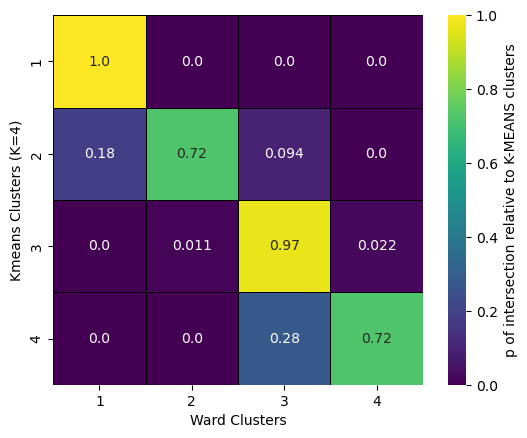

In [87]:
ax = sns.heatmap(pd.DataFrame(intersects, columns = [1,2,3,4], index=[1,2,3,4]), square = True,annot=True, fmt=".2", cmap='viridis', linecolor = "k", linewidth = 0.5, cbar_kws={'label': 'p of intersection relative to K-MEANS clusters'})
plt.ylabel("Kmeans Clusters (K=4)")
plt.xlabel("Ward Clusters")

plt.show()

In [88]:
(1+0.72+0.97+0.72)/4

0.8525

In [89]:
intersects = []
for un_id_ward in un_labs:
    intersects.append([])
    for un_id_kmeans in un_labs:
        intersect = len(ward_membership[un_id_ward].intersection(set(kmeans_membership[un_id_kmeans])))/len(ward_membership[un_id_ward])
        intersects[un_id_ward-1].append(intersect) 

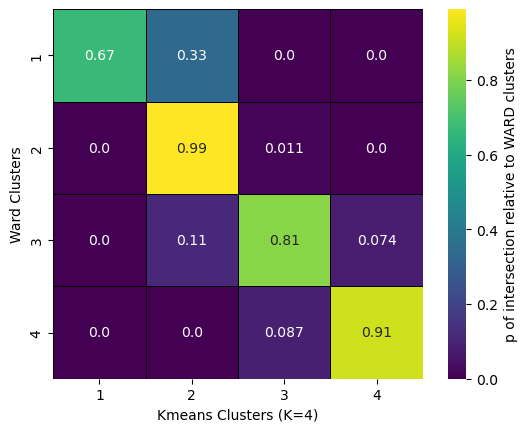

In [90]:
ax = sns.heatmap(pd.DataFrame(intersects, columns = [1,2,3,4], index=[1,2,3,4]), square = True,annot=True, fmt=".2", cmap='viridis', linecolor = "k", linewidth = 0.5, cbar_kws={'label': 'p of intersection relative to WARD clusters'})
plt.ylabel("Ward Clusters")
plt.xlabel("Kmeans Clusters (K=4)")

plt.show()

In [40]:
(0.67+0.99+0.81+0.91)/4

0.8450000000000001

In [91]:
ward_membership_dict = {k: list(v) for k, v in ward_membership.items()}

In [96]:
dump_pickle(ward_membership_dict, os.path.join(results_dir, "rsa_cluster_membership_WARD.pkl"))

In [97]:
dump_pickle(ward_cluster_dict_new, os.path.join(results_dir, "rsa_cluster_dict_WARD.pkl"))